**Labb 2**

Johannes Hedström


# DEL A

In [ ]:
# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

# from tensorflow import keras
# from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.utils  import to_categorical

#print('Keras version:',tf.keras.__version__)

# Helper libraries
import numpy as np
import sklearn
from   sklearn.model_selection import train_test_split

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt



TensorFlow version: 2.12.0


In [ ]:
# Get Fashion-MNIST training and test data from Keras database (https://keras.io/datasets/)
(train_images0, train_labels0), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Define labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Split the training set into a training and a validation set (20% is validation)
train_images, val_images, train_labels, val_labels = train_test_split(train_images0, train_labels0, test_size=0.20)

train_images = np.expand_dims(train_images, -1)
val_images = np.expand_dims(val_images, -1)
test_images = np.expand_dims(test_images, -1)

# Normalize the images.
train_images = (train_images - np.min(train_images)) / (np.max(train_images) - np.min(train_images))
test_images = (test_images - np.min(test_images)) / (np.max(test_images) - np.min(test_images))
val_images = (val_images - np.min(val_images)) / (np.max(val_images) - np.min(val_images))


4422102/4422102 [==============================] - 1s 0us/step


In [ ]:
# Define an in-stream transform (gray2color, resize)
def img_transform(images):
  images = tf.image.grayscale_to_rgb(tf.convert_to_tensor(images))
  images = tf.image.resize_with_pad(images, 32, 32, antialias=False)


  return images

# Ändrar dimensionerna på datamaterialen
train_images=img_transform(train_images)
val_images=img_transform(val_images)
test_images=img_transform(test_images)

In [ ]:
# Kollar så att det blir 32x32x3
print(train_images.shape)
print(val_images.shape)
print(test_images.shape)

(48000, 32, 32, 3)
(12000, 32, 32, 3)
(10000, 32, 32, 3)


Dimensionerna ser nu ut att vara tillräckligt stora för VGG16 som kräver minst 32x32x16

Label: Dress


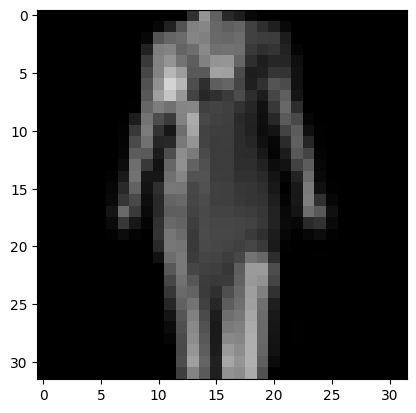

Label: T-shirt/top


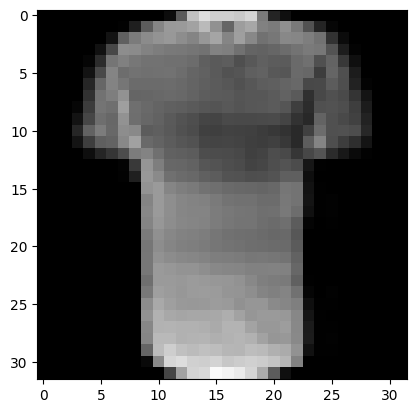

In [ ]:
# As these are images (32x32x3) it can be interesting to plot some as images
image_index = [42, 789] # "Random" images to print

for index in image_index:
  print( 'Label:', class_names[train_labels[index]])
  plt.figure()
  plt.imshow(train_images[index])
  plt.grid(False)
  plt.show(block=False)

Bilderna ser bra ut

Nedan läser jag in VGG16 från Tensorflow och tar vikter så den inte behöver tränas, sedan så väljer jag ut alla lager fram till block3_pool som inte ska tränas utan behålla vikterna.

In [ ]:
input_shape = test_images[0].shape
# VGG16 från keras
vgg_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=input_shape,classes=10)
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:


# Tar alla lager fram till block3_pool från VGG16 och fryser deras vikter med trainable=FALSE
# Skapar en ny modell som kopierar vgg_modell fram till lager 'block3_pool'
inputs = vgg_model.inputs
my_model = vgg_model.get_layer('block3_pool').output

# Fryser alla lagren i modellen
#for layer in my_model.layers:
#  layer.trainable = False

# Lägger till egna lager som ska tränas
my_model = tf.keras.layers.BatchNormalization(axis=-1)(my_model) # normaliserar inputs
my_model = Dropout(0.2)(my_model)  # Dropout på 20% av noderna på faltningslagret som skapas nedan
my_model = Conv2D(filters=96,
                        kernel_size=5,
                        activation='relu',
                        padding='same')(my_model)

my_model=(tf.keras.layers.Flatten())(my_model)  # Ser till så lagren är 'full connected'
my_model=(tf.keras.layers.Dense(64,activation='relu'))(my_model)  # tagit bort ett lager och minskat filter /noder i dom jag lagt in som är kvar
outputs=(Dense(units=10, activation='softmax'))(my_model) #sista lagret
my_model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
# Freeze the layers
for layer in my_model.layers[:-6]:
    layer.trainable = False



my_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

Det är 1.7 miljoner parametrar som har frysta vikter och kommer därav inte att tränas.
Totala antalet parametrar i modellen är ca 2.4 miljoner och då ska alltså mer än 700 000 som tränas.

Lagren jag lagt in kommer efter block3_conv3 i listan ovan och har kommenterat mer tydligt i koden.

In [ ]:
# compilar modellen med adam som optimizer och learning rate på 0.001
my_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy'],

)


In [ ]:
"""
### Importerar earlystopping och skapar earlystop för att stanna träningen när överanpassning sker och låter den gå 3 epoker till för att tillåta att några steg i "fel" riktning
"""
from keras.callbacks import EarlyStopping
earlystop= EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)


In [ ]:


epochs = 50 # Antal epoker som kan köras
batch_size = 96 # batchstoleken

# Train the model.
history = my_model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=(val_images, to_categorical(val_labels)),
  callbacks=[earlystop] # Lägger in earlystopping i träningen
)

# Evaluate the model.
test_loss, test_acc = my_model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

Epoch 1/50
500/500 [==============================] - 8s 13ms/step - loss: 4.6857 - categorical_accuracy: 0.4875 - val_loss: 1.0251 - val_categorical_accuracy: 0.6863
Epoch 2/50
500/500 [==============================] - 6s 12ms/step - loss: 0.9623 - categorical_accuracy: 0.6924 - val_loss: 0.8511 - val_categorical_accuracy: 0.7047
Epoch 3/50
500/500 [==============================] - 7s 13ms/step - loss: 0.7540 - categorical_accuracy: 0.7510 - val_loss: 0.6757 - val_categorical_accuracy: 0.7833
Epoch 4/50
500/500 [==============================] - 6s 12ms/step - loss: 0.5218 - categorical_accuracy: 0.8490 - val_loss: 0.5007 - val_categorical_accuracy: 0.8417
Epoch 5/50
500/500 [==============================] - 6s 12ms/step - loss: 0.4277 - categorical_accuracy: 0.8758 - val_loss: 0.4045 - val_categorical_accuracy: 0.8957
Epoch 6/50
500/500 [==============================] - 7s 13ms/step - loss: 0.3424 - categorical_accuracy: 0.8973 - val_loss: 0.3004 - val_categorical_accuracy: 0.905

Modellen får en testnoggrannhet på 92.1%  och stannar efter 17 epoker då earlystopping stoppar träningen för att förhindra ytterligare överanpassning.






# DEL B
Lagt in träning på ca 66% av lagren från VGG16

In [ ]:
input_shape = test_images[0].shape
# VGG16 från keras
vgg_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=input_shape,classes=10)

# Tar alla lager fram till block3_pool från VGG16 och fryser deras vikter med trainable=FALSE

# Tar alla lager fram till block3_pool från VGG16 och fryser deras vikter med trainable=FALSE
# Skapar en ny modell som kopierar vgg_modell fram till lager 'block3_pool'
inputs = vgg_model.inputs
my_model = vgg_model.get_layer('block3_pool').output

# Fryser alla lagren i modellen
#for layer in my_model.layers:
#  layer.trainable = False

# Lägger till egna lager som ska tränas
my_model = tf.keras.layers.BatchNormalization(axis=-1)(my_model) # normaliserar inputs
my_model = Dropout(0.2)(my_model)  # Dropout på 20% av noderna på faltningslagret som skapas nedan
my_model = Conv2D(filters=96,
                        kernel_size=5,
                        activation='relu',
                        padding='same')(my_model)

my_model=(tf.keras.layers.Flatten())(my_model)  # Ser till så lagren är 'full connected'
my_model=(tf.keras.layers.Dense(64,activation='relu'))(my_model)  # tagit bort ett lager och minskat filter /noder i dom jag lagt in som är kvar
outputs=(Dense(units=10, activation='softmax'))(my_model) #sista lagret
my_model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

# Gör så att det går att träna lagren
for layer in my_model.layers:
  layer.trainable = True

# Freeze the layers
for layer in my_model.layers[:-9]:
    layer.trainable = False


my_model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0  

Nu ser vi att det är fler parametrar som ska tränas än tidigare då runt 30% av de frysta lagren nu också ska tränas, endast 555,840 av alla parametrar är frysta.



In [ ]:
my_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # ändrat inlärningstakten
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy'],

)


epochs = 50 # Antal epoker som kan köras
batch_size = 96 # batchstoleken

# Train the model.
history = my_model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=(val_images, to_categorical(val_labels)),
  callbacks=[earlystop] # Lägger in earlystopping i träningen
)

# Evaluate the model.
test_loss, test_acc = my_model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

Epoch 1/50
500/500 [==============================] - 11s 17ms/step - loss: 0.3410 - categorical_accuracy: 0.8795 - val_loss: 0.2601 - val_categorical_accuracy: 0.9067
Epoch 2/50
500/500 [==============================] - 8s 16ms/step - loss: 0.2237 - categorical_accuracy: 0.9189 - val_loss: 0.2337 - val_categorical_accuracy: 0.9159
Epoch 3/50
500/500 [==============================] - 8s 16ms/step - loss: 0.1871 - categorical_accuracy: 0.9313 - val_loss: 0.2133 - val_categorical_accuracy: 0.9224
Epoch 4/50
500/500 [==============================] - 8s 16ms/step - loss: 0.1613 - categorical_accuracy: 0.9408 - val_loss: 0.2081 - val_categorical_accuracy: 0.9237
Epoch 5/50
500/500 [==============================] - 8s 17ms/step - loss: 0.1390 - categorical_accuracy: 0.9492 - val_loss: 0.1977 - val_categorical_accuracy: 0.9283
Epoch 6/50
500/500 [==============================] - 9s 17ms/step - loss: 0.1222 - categorical_accuracy: 0.9548 - val_loss: 0.2231 - val_categorical_accuracy: 0.92

Flärre epoker körs nu än tidigare 8 vs 17 och testnoggranheten har ökat från 92.1% till 92.7%.

Så att träna fler vikter efter just detta datamaterial ger ett bättre resultat i slutändan.

# DEL X

In [ ]:
# Ändrar så datat är rätt dimensioner
train_images=tf.image.resize_with_pad(train_images, 72, 72, antialias=False)
val_images=tf.image.resize_with_pad(val_images, 72, 72, antialias=False)
test_images=tf.image.resize_with_pad(test_images, 72, 72, antialias=False)

print(train_images.shape)
print(val_images.shape)
print(test_images.shape)

(48000, 72, 72, 3)
(12000, 72, 72, 3)
(10000, 72, 72, 3)


Datat har dimensionerats om rätt

Label: Coat


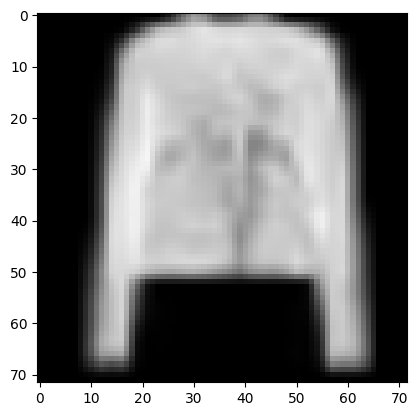

Label: Sneaker


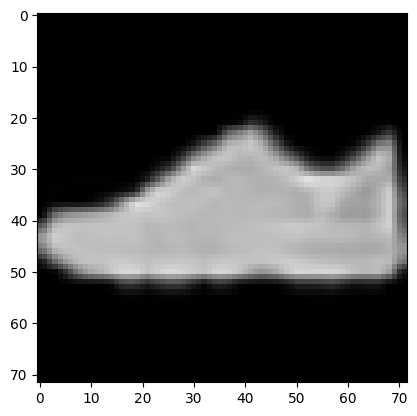

In [ ]:
image_index = [42, 789] # "Random" images to print

for index in image_index:
  print( 'Label:', class_names[train_labels[index]])
  plt.figure()
  plt.imshow(train_images[index])
  plt.grid(False)
  plt.show(block=False)

Bilderna ser bra ut

In [ ]:
input_shape = test_images[0].shape
# Xception från keras
Xception_model = tf.keras.applications.Xception(include_top=False, weights="imagenet", input_shape=input_shape,classes=10)
Xception_model.summary()

83683744/83683744 [==============================] - 3s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 72, 72, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 35, 35, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 35, 35, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                                  
 block1_conv1_act (Activat

Output shape får sitt minsta värde vid conv2D_3, men vid conv2D_2 så går den länge på output =(5,5,728) så väljer det lagret. Efter att ha testat några modeller väljer jag att utgå från block5_sepconv1 istället för att få fler parametrar från xception-modellen men samtidigt inte använda alla 126 lager.

In [ ]:
# Väljer ut output vid conv2D_3
X_model = tf.keras.models.Model(inputs=Xception_model.inputs, outputs=Xception_model.get_layer('block5_sepconv1').output )

In [ ]:
X_model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 72, 72, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 35, 35, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 35, 35, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                                  
 block1_conv1_act (Activation)  (None, 35, 35, 32)   0           ['block1_conv1_bn[0][0]'] 

Modellen jag utgår ifrån har ca 1,650,160  parametrar innan jag lägger in fler lager.

In [ ]:
# Väljer ut output vid conv2D_3
inputs = Xception_model.inputs

X = Xception_model.get_layer('block5_sepconv1').output



# Lägger till egna lager som ska tränas
X= tf.keras.layers.BatchNormalization(axis=-1)(X) # normaliserar inputs
X= (Dropout(0.2))(X) # Dropout på 20% av noderna på faltningslagret som skapas nedan
X=(Conv2D(filters=96,
                        kernel_size=5,
                        activation='relu',
                        padding='same'))(X)

X=(tf.keras.layers.Flatten())(X) # Ser till så lagren är 'full connected'
# X_model.add(tf.keras.layers.Dense(294,activation='relu'))# Lägger in 2 gömda lager med olika antal noder
X=(tf.keras.layers.Dense(64,activation='relu'))(X)
outputs=(Dense(units=10, activation='softmax'))(X) #sista lagret


X_model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
# Freeze the layers
for layer in X_model.layers[:-6]:
    layer.trainable = False

X_model.summary()


Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 72, 72, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 35, 35, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 35, 35, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                                  
 block1_conv1_act (Activation)  (None, 35, 35, 32)   0           ['block1_conv1_bn[0][0]'] 

Modellen har 1,651,616 parametrar som inte tränas och runt 3.5 miljoner totalt, så om jag kör med samma storlek på lagren som i tidigare uppgifter utgör nu mina tillagda lager en stor del av alla parametrar i modellen. Bör här möjligtvis minska mina lager något men väljer att köra på med samma tillagda lager för att utvärdera de inlästa modellerna snarare än mina lager.


 Valde antalet lager efter att titta på hur outputen såg ut och valde ett lager med liten output där outputen inte förändrades på länge.

In [ ]:
X_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy'],

)


epochs = 50 # Antal epoker som kan köras
batch_size = 96 # batchstoleken

# Train the model.
history = X_model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=(val_images, to_categorical(val_labels)),
  callbacks=[earlystop] # Lägger in earlystopping i träningen
)

# Evaluate the model.
test_loss, test_acc = X_model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

Epoch 1/50
500/500 [==============================] - 20s 35ms/step - loss: 0.3586 - categorical_accuracy: 0.8800 - val_loss: 0.2405 - val_categorical_accuracy: 0.9172
Epoch 2/50
500/500 [==============================] - 20s 40ms/step - loss: 0.2155 - categorical_accuracy: 0.9212 - val_loss: 0.2050 - val_categorical_accuracy: 0.9293
Epoch 3/50
500/500 [==============================] - 17s 34ms/step - loss: 0.1815 - categorical_accuracy: 0.9342 - val_loss: 0.2383 - val_categorical_accuracy: 0.9197
Epoch 4/50
500/500 [==============================] - 17s 35ms/step - loss: 0.1591 - categorical_accuracy: 0.9417 - val_loss: 0.2065 - val_categorical_accuracy: 0.9293
Epoch 5/50
500/500 [==============================] - 17s 34ms/step - loss: 0.1418 - categorical_accuracy: 0.9480 - val_loss: 0.1976 - val_categorical_accuracy: 0.9336
Epoch 6/50
500/500 [==============================] - 17s 34ms/step - loss: 0.1311 - categorical_accuracy: 0.9521 - val_loss: 0.2159 - val_categorical_accuracy:

Modellen tränas i 8 epoker och får en testnoggrannhet på 93.1% och är således den bästa modellen av de jag skapat i labben.
